# Overview

## What to Predict

- Stage 1 - You should submit predicted probabilities for every possible matchup in the past 5 NCAA® tournaments (seasons 2015-2019).
- Stage 2 - You should submit predicted probabilities for every possible matchup before the 2020 tournament begins.

Refer to the [Timeline page](https://www.kaggle.com/c/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/overview/timeline) for specific dates. In both stages, the sample submission will tell you which games to predict.

# Import Packages

In [4]:
import os

########################################## basic packages

import pandas as pd
import numpy as np

########################################## plotting packages

# matplotlib
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 20, 6

# Bokeh
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral6, Spectral10


########################################## utility

# To print multiple output in a single cell.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

########################################## Dimension Reduction


########################################## Modeling

# Train Test Split
from sklearn.model_selection import train_test_split

# Scaler
from sklearn.preprocessing import MinMaxScaler

# Sklearn
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


from tsfresh.feature_extraction import feature_calculators as fc

# Data Download

# Data Import

In [5]:
def get_file_list(datapath):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(datapath)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(datapath, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + get_file_list(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [6]:
main_path = 'D:\\OneDrive - Georgia State University\\Data Science\\Competition\\Data\\Google Cloud & NCAA® ML Competition 2020-NCAAM\\'

sub_folders = os.listdir(main_path)
path1 = main_path + sub_folders[0] + '\\'
path2 = main_path + sub_folders[1] + '\\'
path3 = main_path + sub_folders[2] + '\\'

saving_path = main_path + sub_folders[-1] + '\\'


# Get the list of all files in directory tree at given path
data_list1 = get_file_list(path1)
data_list2 = get_file_list(path2)
data_list3 = get_file_list(path3)


data_list1
data_list2
data_list3

['D:\\OneDrive - Georgia State University\\Data Science\\Competition\\Data\\Google Cloud & NCAA® ML Competition 2020-NCAAM\\Data Section 1 - The Basics\\MNCAATourneyCompactResults.csv',
 'D:\\OneDrive - Georgia State University\\Data Science\\Competition\\Data\\Google Cloud & NCAA® ML Competition 2020-NCAAM\\Data Section 1 - The Basics\\MNCAATourneySeeds.csv',
 'D:\\OneDrive - Georgia State University\\Data Science\\Competition\\Data\\Google Cloud & NCAA® ML Competition 2020-NCAAM\\Data Section 1 - The Basics\\MRegularSeasonCompactResults.csv',
 'D:\\OneDrive - Georgia State University\\Data Science\\Competition\\Data\\Google Cloud & NCAA® ML Competition 2020-NCAAM\\Data Section 1 - The Basics\\MSampleSubmissionStage1_2020.csv',
 'D:\\OneDrive - Georgia State University\\Data Science\\Competition\\Data\\Google Cloud & NCAA® ML Competition 2020-NCAAM\\Data Section 1 - The Basics\\MSeasons.csv',
 'D:\\OneDrive - Georgia State University\\Data Science\\Competition\\Data\\Google Cloud & NC

['D:\\OneDrive - Georgia State University\\Data Science\\Competition\\Data\\Google Cloud & NCAA® ML Competition 2020-NCAAM\\Data Section 2 - Team Box Scores\\MNCAATourneyDetailedResults.csv',
 'D:\\OneDrive - Georgia State University\\Data Science\\Competition\\Data\\Google Cloud & NCAA® ML Competition 2020-NCAAM\\Data Section 2 - Team Box Scores\\MRegularSeasonDetailedResults.csv']

['D:\\OneDrive - Georgia State University\\Data Science\\Competition\\Data\\Google Cloud & NCAA® ML Competition 2020-NCAAM\\Data Section 3 - Geography\\Cities.csv',
 'D:\\OneDrive - Georgia State University\\Data Science\\Competition\\Data\\Google Cloud & NCAA® ML Competition 2020-NCAAM\\Data Section 3 - Geography\\MGameCities.csv']

In [7]:
tourney_compact_result_M = pd.read_csv(path1 + 'MNCAATourneyCompactResults.csv')
tourney_seed_M = pd.read_csv(path1 + 'MNCAATourneySeeds.csv')
regular_compact_result_M = pd.read_csv(path1 + 'MRegularSeasonCompactResults.csv')
season_M = pd.read_csv(path1 + 'MSeasons.csv')
teams_M = pd.read_csv(path1 + 'MTeams.csv')

submission_file = pd.read_csv(path1 + 'MSampleSubmissionStage1_2020.csv')

cities_game_M = pd.read_csv(path3 + 'MGameCities.csv')
cities = pd.read_csv(path3 + 'Cities.csv')

# Data Preparation

In [8]:
# create a column indicating that the data is from regular seasons or tournaments.
tourney_compact_result_M['CRType'] = "NCAA"
regular_compact_result_M['CRType'] = "Regular"


# Concatenate the tourney and regular compact results.
entire_compact_result_M = pd.concat([regular_compact_result_M, tourney_compact_result_M])

# Create a match up column with lower TeamID comes first.
entire_compact_result_M['match_up'] = entire_compact_result_M[['WTeamID', 'LTeamID']].values.tolist()
entire_compact_result_M['match_up'] = entire_compact_result_M['match_up'].apply(sorted)


# Combine city that each game was played.
entire_compact_result_M = pd.merge(entire_compact_result_M, cities_game_M,  how='left', on=['Season','DayNum','WTeamID','LTeamID','CRType'])
entire_compact_result_M = pd.merge(entire_compact_result_M, cities,  how='left', on=['CityID'])


# check the non-null count and the data types. 
entire_compact_result_M

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,CRType,match_up,CityID,City,State
0,1985,20,1228,81,1328,64,N,0,Regular,"[1228, 1328]",NaN,NaN,NaN
1,1985,25,1106,77,1354,70,H,0,Regular,"[1106, 1354]",NaN,NaN,NaN
2,1985,25,1112,63,1223,56,H,0,Regular,"[1112, 1223]",NaN,NaN,NaN
3,1985,25,1165,70,1432,54,H,0,Regular,"[1165, 1432]",NaN,NaN,NaN
4,1985,25,1192,86,1447,74,H,0,Regular,"[1192, 1447]",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
163798,2019,146,1120,77,1246,71,N,1,NCAA,"[1120, 1246]",4174.0,Kansas City,MO
163799,2019,146,1277,68,1181,67,N,0,NCAA,"[1181, 1277]",4363.0,Washington,DC
163800,2019,152,1403,61,1277,51,N,0,NCAA,"[1277, 1403]",4216.0,Minneapolis,MN
163801,2019,152,1438,63,1120,62,N,0,NCAA,"[1120, 1438]",4216.0,Minneapolis,MN


In [9]:
tourney_seed_M

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374
...,...,...,...
2281,2019,Z12,1332
2282,2019,Z13,1414
2283,2019,Z14,1330
2284,2019,Z15,1159


In [10]:
winners = entire_compact_result_M.copy()
winners['Result'] = 1
winners = winners.rename(columns={"WTeamID": "TeamID", "LTeamID": "Opp_TeamID", "WScore": "Score", "LScore": "Opp_Score"})
len(winners)

losers = entire_compact_result_M.copy()
losers['Result'] = 0
losers = losers.rename(columns={"LTeamID": "TeamID", "WTeamID": "Opp_TeamID", "LScore": "Score", "WScore": "Opp_Score"})
len(losers)


final_data = pd.concat([winners, losers])

# Seed information
tourney_seed_M['CRType'] = 'NCAA' # create a column in seed table to merge only on NCAA data.
final_data = pd.merge(final_data, tourney_seed_M, how = 'left', left_on=['Season', 'TeamID', 'CRType'], right_on=['Season','TeamID', 'CRType'])
final_data['Seed_Group'] = final_data['Seed'].apply(lambda x: x[0] if (np.all(pd.notnull(x))) else x)
final_data['Seed_Number'] = final_data['Seed'].apply(lambda x: x[1:3] if (np.all(pd.notnull(x))) else x)
final_data.drop('Seed', axis = 1, inplace =True)


opp_team_name = tourney_seed_M.rename(columns={"TeamID": "Opp_TeamID"})
final_data = pd.merge(final_data, opp_team_name, how = 'left', left_on=['Season', 'Opp_TeamID', 'CRType'], right_on=['Season','Opp_TeamID', 'CRType'])
final_data['Opp_Seed_Group'] = final_data['Seed'].apply(lambda x: x[0] if (np.all(pd.notnull(x))) else x)
final_data['Opp_Seed_Number'] = final_data['Seed'].apply(lambda x: x[1:3] if (np.all(pd.notnull(x))) else x)


# Team Name
final_data['Team_Name'] = final_data['TeamID'].map(teams_M.set_index('TeamID')['TeamName'])
final_data['Opp_Team_Name'] = final_data['Opp_TeamID'].map(teams_M.set_index('TeamID')['TeamName'])

len(final_data)
final_data.to_csv(saving_path + 'final_data.csv', index=False)
final_data

163803

163803

327606

,Season,DayNum,TeamID,Score,Opp_TeamID,Opp_Score,WLoc,NumOT,CRType,match_up,...,City,State,Result,Seed_Group,Seed_Number,Seed,Opp_Seed_Group,Opp_Seed_Number,Team_Name,Opp_Team_Name
0,1985,20,1228,81,1328,64,N,0,Regular,"[1228, 1328]",...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,Illinois,Oklahoma
1,1985,25,1106,77,1354,70,H,0,Regular,"[1106, 1354]",...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,Alabama St,S Carolina St
2,1985,25,1112,63,1223,56,H,0,Regular,"[1112, 1223]",...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,Arizona,Houston Bap
3,1985,25,1165,70,1432,54,H,0,Regular,"[1165, 1432]",...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,Cornell,Utica
4,1985,25,1192,86,1447,74,H,0,Regular,"[1192, 1447]",...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,F Dickinson,Wagner
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327601,2019,146,1246,71,1120,77,N,1,NCAA,"[1120, 1246]",...,Kansas City,MO,0,Y,02,Y05,Y,05,Kentucky,Auburn
327602,2019,146,1181,67,1277,68,N,0,NCAA,"[1181, 1277]",...,Washington,DC,0,W,01,W02,W,02,Duke,Michigan St
327603,2019,152,1277,51,1403,61,N,0,NCAA,"[1277, 1403]",...,Minneapolis,MN,0,W,02,X03,X,03,Michigan St,Texas Tech
327604,2019,152,1120,62,1438,63,N,0,NCAA,"[1120, 1438]",...,Minneapolis,MN,0,Y,05,Z01,Z,01,Auburn,Virginia


# Exploratory Data Analysis

    - for each data we will:
        - handle missing values
        - find-out meaningful information that can potentially affect the result of the game
        - create a new feature within the data

## Head-to-Head Record

In [11]:
# Check if any teamID skipped
unique_teams = np.sort(final_data['TeamID'].unique())
checker = np.arange(unique_teams[0],unique_teams[-1]+1)
mask = np.isin(unique_teams, checker,  invert=True)


unique_teams[mask]

array([], dtype=int64)

**No teamID was skipped, we can safely choose any number from 1101 to 1466 to see the head-to-head result**

**Since there are too many pairs of match ups, I looked for the most matched up pair**  

In [12]:
head_to_head_eda = final_data.groupby(['Team_Name','Opp_Team_Name']).count()
head_to_head_eda = head_to_head_eda[['Result']]

head_to_head_eda[head_to_head_eda.Result == head_to_head_eda.Result.max()]

,,Result
Team_Name,Opp_Team_Name,
Kansas,Kansas St,88
Kansas St,Kansas,88


In [13]:
teams_M[teams_M['TeamName']=='Kansas']
teams_M[teams_M['TeamName']=='Kansas St']

,TeamID,TeamName,FirstD1Season,LastD1Season
141,1242,Kansas,1985,2020


,TeamID,TeamName,FirstD1Season,LastD1Season
142,1243,Kansas St,1985,2020


In [14]:
def head_to_head(Team1, Team2, final_data = final_data):
    head_to_head1 = final_data[(final_data['TeamID'] == Team1) & (final_data['Opp_TeamID'] == Team2)]
    head_to_head2 = final_data[(final_data['Opp_TeamID'] == Team1) & (final_data['TeamID'] == Team2)]

    final_head_to_head = pd.concat([head_to_head1, head_to_head2])
    return final_head_to_head

# Team from 1101~1466
Team1 = 1242
Team2 = 1243

head_to_head_record = head_to_head(Team1, Team2)
head_to_head_record

# To see the record only from Tournaments
head_to_head_record[head_to_head_record['CRType']=='NCAA']

,Season,DayNum,TeamID,Score,Opp_TeamID,Opp_Score,WLoc,NumOT,CRType,match_up,...,City,State,Result,Seed_Group,Seed_Number,Seed,Opp_Seed_Group,Opp_Seed_Number,Team_Name,Opp_Team_Name
2219,1985,93,1242,75,1243,57,A,0,Regular,"[1242, 1243]",...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,Kansas,Kansas St
3065,1985,114,1242,75,1243,64,H,0,Regular,"[1242, 1243]",...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,Kansas,Kansas St
6132,1986,96,1242,64,1243,50,A,0,Regular,"[1242, 1243]",...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,Kansas,Kansas St
6983,1986,117,1242,84,1243,69,H,0,Regular,"[1242, 1243]",...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,Kansas,Kansas St
7392,1986,128,1242,74,1243,51,N,0,Regular,"[1242, 1243]",...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,Kansas,Kansas St
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317289,2018,75,1243,72,1242,73,H,0,Regular,"[1242, 1243]",...,Lawrence,KS,0,NaN,NaN,NaN,NaN,NaN,Kansas St,Kansas
318058,2018,91,1243,56,1242,70,A,0,Regular,"[1242, 1243]",...,Manhattan,KS,0,NaN,NaN,NaN,NaN,NaN,Kansas St,Kansas
319835,2018,130,1243,67,1242,83,N,0,Regular,"[1242, 1243]",...,Kansas City,MO,0,NaN,NaN,NaN,NaN,NaN,Kansas St,Kansas
324534,2019,112,1243,49,1242,64,H,0,Regular,"[1242, 1243]",...,Lawrence,KS,0,NaN,NaN,NaN,NaN,NaN,Kansas St,Kansas


,Season,DayNum,TeamID,Score,Opp_TeamID,Opp_Score,WLoc,NumOT,CRType,match_up,...,City,State,Result,Seed_Group,Seed_Number,Seed,Opp_Seed_Group,Opp_Seed_Number,Team_Name,Opp_Team_Name
161800,1988,146,1242,71,1243,58,N,0,NCAA,"[1242, 1243]",...,NaN,NaN,1,X,06,X04,X,04,Kansas,Kansas St
325603,1988,146,1243,58,1242,71,N,0,NCAA,"[1242, 1243]",...,NaN,NaN,0,X,04,X06,X,06,Kansas St,Kansas


In [15]:
def reorder_team(TeamID, Opp_TeamID, Result):

    if TeamID > Opp_TeamID:
        TeamID, Opp_TeamID = Opp_TeamID, TeamID
        Result = 1 - Result

    return TeamID, Opp_TeamID, Result

# Generate data and get summary by team match-ups
TeamID, Opp_TeamID, Result = final_data['TeamID'], final_data['Opp_TeamID'], final_data['Result']

df = pd.DataFrame(data={'TeamID':TeamID,'Opp_TeamID':Opp_TeamID,'Result':Result}, dtype='int')
df = pd.DataFrame(df.apply(lambda x : reorder_team(x['TeamID'], x['Opp_TeamID'], x['Result']),axis=1).to_list(), 
                  columns=df.columns)


df_summary = df.groupby(['TeamID','Opp_TeamID']).agg(['sum','count'])
df_summary.columns = ['Wins', 'Total']

df_summary.reset_index(inplace=True)
df_summary['Team_Winrate'] = (df_summary['Wins'] / df_summary['Total'])

df_summary['Opp_Team_Winrate'] = 1 - df_summary['Team_Winrate']
df_summary = df_summary.sort_values('Total', ascending=False)

In [16]:
Team1 = 1242
Team2 = 1243

head_to_head_record = head_to_head(Team1, Team2, df_summary)
head_to_head_record

,TeamID,Opp_TeamID,Wins,Total,Team_Winrate,Opp_Team_Winrate
16361,1242,1243,152,176,0.863636,0.136364


**I included the top 10 most match ups to visualize**

In [17]:
df_summary = df_summary.iloc[:10,:]
df_summary

,TeamID,Opp_TeamID,Wins,Total,Team_Winrate,Opp_Team_Winrate
16361,1242,1243,152,176,0.863636,0.136364
13509,1211,1388,126,174,0.724138,0.275862
4532,1137,1250,106,168,0.630952,0.369048
13492,1211,1360,130,168,0.773810,0.226190
10101,1181,1314,90,166,0.542169,0.457831
23363,1337,1360,92,164,0.560976,0.439024
20581,1290,1411,72,164,0.439024,0.560976
16356,1241,1456,78,164,0.475610,0.524390
711,1106,1238,64,164,0.390244,0.609756
24637,1365,1388,76,164,0.463415,0.536585


<ipython-input-18-d655706829c8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_summary['Team_Name'] = final_data['TeamID'].map(teams_M.set_index('TeamID')['TeamName'])
<ipython-input-18-d655706829c8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_summary['Opp_Team_Name'] = final_data['Opp_TeamID'].map(teams_M.set_index('TeamID')['TeamName'])


<BarContainer object of 10 artists>

[Text(0, 0, 'Lamar VS Rice'),
 Text(0, 0, 'North Carolina VS NC State'),
 Text(0, 0, 'Wichita St VS New Orleans'),
 Text(0, 0, 'Valparaiso VS W Illinois'),
 Text(0, 0, 'WKU VS Old Dominion'),
 Text(0, 0, 'Chicago St VS Missouri KC'),
 Text(0, 0, 'Lamar VS SF Austin'),
 Text(0, 0, 'Houston VS Alcorn St'),
 Text(0, 0, 'SMU VS Campbell'),
 Text(0, 0, 'Austin Peay VS Rice')]

Text(0.5, 1.0, 'Total No. of Match Ups')

[]

Text(-5, 0, '176')

Text(-5, 0, '174')

Text(-5, 0, '168')

Text(-5, 0, '168')

Text(-5, 0, '166')

Text(-5, 0, '164')

Text(-5, 0, '164')

Text(-5, 0, '164')

Text(-5, 0, '164')

Text(-5, 0, '164')

<BarContainer object of 10 artists>

<BarContainer object of 10 artists>

[Text(0, 0, 'Lamar'),
 Text(0, 0, 'North Carolina'),
 Text(0, 0, 'Wichita St'),
 Text(0, 0, 'Valparaiso'),
 Text(0, 0, 'WKU'),
 Text(0, 0, 'Chicago St'),
 Text(0, 0, 'Lamar'),
 Text(0, 0, 'Houston'),
 Text(0, 0, 'SMU'),
 Text(0, 0, 'Austin Peay')]

[Text(1, 0, 'Rice'),
 Text(1, 0, 'NC State'),
 Text(1, 0, 'New Orleans'),
 Text(1, 0, 'W Illinois'),
 Text(1, 0, 'Old Dominion'),
 Text(1, 0, 'Missouri KC'),
 Text(1, 0, 'SF Austin'),
 Text(1, 0, 'Alcorn St'),
 Text(1, 0, 'Campbell'),
 Text(1, 0, 'Rice')]

(0, 1)

Text(0.5, 1.0, 'Winning Rate')

[]

Text(10, 0, '86 %')

Text(-10, 0, '14 %')

Text(10, 0, '72 %')

Text(-10, 0, '28 %')

Text(10, 0, '63 %')

Text(-10, 0, '37 %')

Text(10, 0, '77 %')

Text(-10, 0, '23 %')

Text(10, 0, '54 %')

Text(-10, 0, '46 %')

Text(10, 0, '56 %')

Text(-10, 0, '44 %')

Text(10, 0, '44 %')

Text(-10, 0, '56 %')

Text(10, 0, '48 %')

Text(-10, 0, '52 %')

Text(10, 0, '39 %')

Text(-10, 0, '61 %')

Text(10, 0, '46 %')

Text(-10, 0, '54 %')

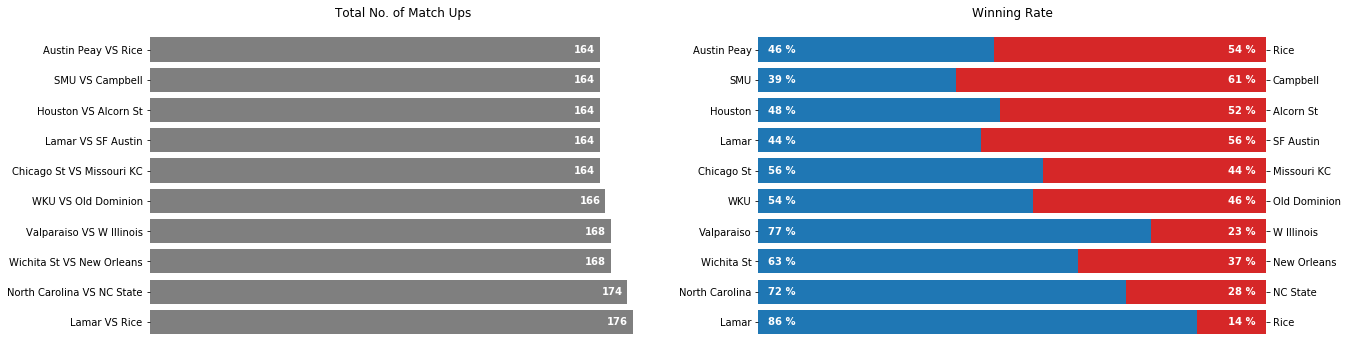

In [18]:
fig, (ax_count, ax_win) = plt.subplots(1,2, figsize=(20,6))

df_summary = df_summary.iloc[:10,:]
df_summary['Team_Name'] = final_data['TeamID'].map(teams_M.set_index('TeamID')['TeamName'])
df_summary['Opp_Team_Name'] = final_data['Opp_TeamID'].map(teams_M.set_index('TeamID')['TeamName'])

y_locs = list(range(len(df_summary)))

ax_count.barh(y_locs, width=df_summary['Total'], color='tab:gray')
ax_count.set_yticks(y_locs)
ax_count.set_yticklabels(df_summary['Team_Name'] + ' VS ' + df_summary['Opp_Team_Name'])
ax_count.set_title('Total No. of Match Ups')
ax_count.set_xticks([])

for loc in ['top','left','right','bottom']:
    ax_count.spines[loc].set_visible(False)

for p in ax_count.patches:
    ax_count.annotate(f'{p.get_width()}',
                      (p.get_x() + p.get_width(), p.get_y() + p.get_height()/2.), 
                      ha='right', va='center', xytext=(-5,0), textcoords='offset points', 
                      color='white',fontweight='heavy')

ax_win.barh(y_locs, width=df_summary['Team_Winrate'], color='tab:blue')
ax_win2 = ax_win.twinx()
ax_win2.barh(y_locs, width=df_summary['Opp_Team_Winrate'], 
             left=df_summary['Team_Winrate'], color='tab:red')

ax_win.set_yticks(y_locs)
ax_win.set_yticklabels(df_summary['Team_Name'])
ax_win2.set_yticks(y_locs)
ax_win2.set_yticklabels(df_summary['Opp_Team_Name'])

ax_win.set_xlim(0,1)
ax_win.set_title('Winning Rate')
ax_win.set_xticks([])

for loc in ['top','left','right','bottom']:
    ax_win.spines[loc].set_visible(False)
    ax_win2.spines[loc].set_visible(False)

for p in ax_win.patches:
    ax_win.annotate(f'{p.get_width() * 100 :.0f} %',
                      (0, p.get_y() + p.get_height()/2.), 
                      ha='left', va='center', xytext=(10,0), textcoords='offset points', 
                      color='white',fontweight='heavy')

    ax_win2.annotate(f'{(1 - p.get_width()) * 100 :.0f} %',
                      (1, p.get_y() + p.get_height()/2.), 
                      ha='right', va='center', xytext=(-10,0), textcoords='offset points', 
                      color='white',fontweight='heavy')

plt.show()

## Teams Data

    1) Which team won the most
    2) Which team lost the most
    
    3) Level 2
        3) For each team, see what is their strengths and weakness
            - use the detailed results find the point percetage (3points, 2point jumper, under the basket, free throw...etc) to get a sense what were their strategies were. 
            - count the each detailed move, and compare with other teams to see what their strengths and weaknesses are.

In [19]:
# Just to make sure, check if there is any team never won or lost.

a = teams_M['TeamID']
b = entire_compact_result_M['WTeamID']
c = entire_compact_result_M['LTeamID']

print(f'never won: {np.setdiff1d(a,b)}')
print(f'never lost: {np.setdiff1d(a,c)}')

teams_M[teams_M['TeamID']==1467]

never won: [1467]
never lost: [1467]


,TeamID,TeamName,FirstD1Season,LastD1Season
366,1467,Merrimack,2020,2020


We have one team who never won and lost, but Team 1467 just joined the Division 1 this year.

### Which team won the most?

In [20]:
winners

,Season,DayNum,TeamID,Score,Opp_TeamID,Opp_Score,WLoc,NumOT,CRType,match_up,CityID,City,State,Result
0,1985,20,1228,81,1328,64,N,0,Regular,"[1228, 1328]",NaN,NaN,NaN,1
1,1985,25,1106,77,1354,70,H,0,Regular,"[1106, 1354]",NaN,NaN,NaN,1
2,1985,25,1112,63,1223,56,H,0,Regular,"[1112, 1223]",NaN,NaN,NaN,1
3,1985,25,1165,70,1432,54,H,0,Regular,"[1165, 1432]",NaN,NaN,NaN,1
4,1985,25,1192,86,1447,74,H,0,Regular,"[1192, 1447]",NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163798,2019,146,1120,77,1246,71,N,1,NCAA,"[1120, 1246]",4174.0,Kansas City,MO,1
163799,2019,146,1277,68,1181,67,N,0,NCAA,"[1181, 1277]",4363.0,Washington,DC,1
163800,2019,152,1403,61,1277,51,N,0,NCAA,"[1277, 1403]",4216.0,Minneapolis,MN,1
163801,2019,152,1438,63,1120,62,N,0,NCAA,"[1120, 1438]",4216.0,Minneapolis,MN,1


In [21]:
vic_count = winners[['TeamID','Result']].groupby('TeamID', as_index=False).sum()
vic_count = pd.merge(vic_count, teams_M[['TeamID','TeamName']],  how='left', on=['TeamID'])
vic_count.sort_values(by=['Result'], ascending=False, inplace=True)
vic_count

,TeamID,Result,TeamName
80,1181,998,Duke
141,1242,969,Kansas
213,1314,930,North Carolina
145,1246,928,Kentucky
11,1112,874,Arizona
...,...,...,...
364,1465,12,Cal Baptist
365,1466,7,North Alabama
188,1289,6,Morris Brown
17,1118,6,Armstrong St


After I look at the table above, I realize that just counting the number of victory doesn't mean that much. So I divided the count of score, NumOT, and number of wins by number of season each team played. It will give us the average victories per season which means more than the naive count.

In [22]:
season_count = winners[['Season','TeamID']].groupby('TeamID').nunique()
season_count.drop('TeamID', inplace=True, axis =1)
season_count.rename(columns={"Season": "Season_Count"},inplace=True)
#season_count.reset_index(inplace=True)

season_count

,Season_Count
TeamID,
1101,6
1102,35
1103,35
1104,35
1105,20
...,...
1462,35
1463,35
1464,35


In [23]:
victory_count = pd.merge(vic_count, season_count, how = 'left', on=['TeamID'])
victory_count.set_index(['TeamID','TeamName'], inplace = True)
victory_count = victory_count.loc[:,:"Result"].div(victory_count["Season_Count"], axis=0)
victory_count.sort_values(by=['Result'], ascending=False, inplace=True)
victory_count = victory_count.round(2)
victory_count.reset_index(inplace=True)

victory_count

,TeamID,TeamName,Result
0,1181,Duke,28.51
1,1242,Kansas,27.69
2,1314,North Carolina,26.57
3,1246,Kentucky,26.51
4,1112,Arizona,24.97
...,...,...,...
361,1109,Alliant Intl,6.00
362,1152,Chicago St,6.00
363,1118,Armstrong St,6.00
364,1289,Morris Brown,3.00


<Figure size 1440x432 with 0 Axes>

Text(0.5, 1.0, 'Avg. Loses per Season')

Text(0.5, 0, 'Teams')

Text(0, 0.5, 'Wins')

[Text(0, 0, 'Duke'),
 Text(0, 0, 'Kansas'),
 Text(0, 0, 'North Carolina'),
 Text(0, 0, 'Kentucky'),
 Text(0, 0, 'Arizona'),
 Text(0, 0, 'Syracuse'),
 Text(0, 0, 'Michigan St'),
 Text(0, 0, 'Louisville'),
 Text(0, 0, 'Gonzaga'),
 Text(0, 0, 'Memphis'),
 Text(0, 0, 'Connecticut'),
 Text(0, 0, 'Xavier'),
 Text(0, 0, 'UCLA'),
 Text(0, 0, 'Cincinnati'),
 Text(0, 0, 'Oklahoma')]

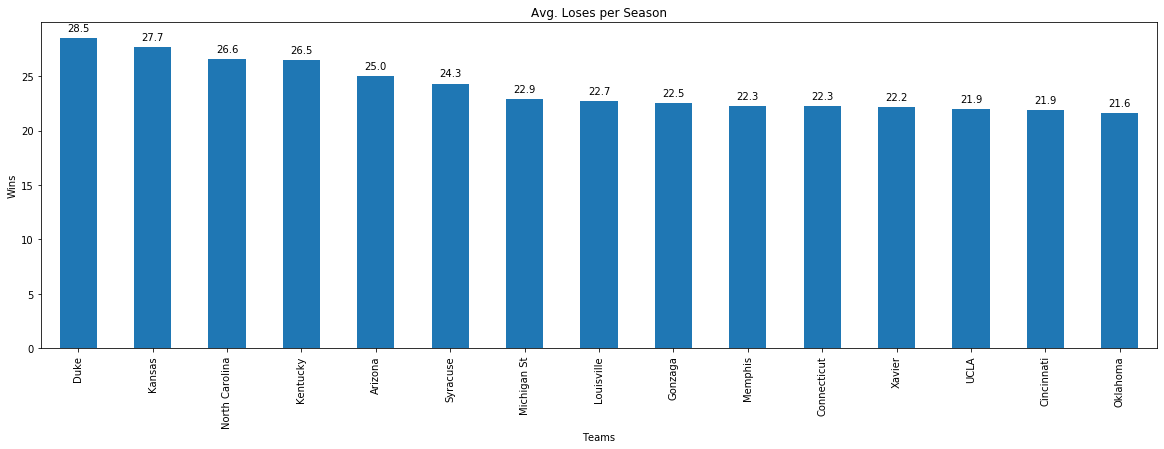

In [24]:
#import seaborn as sns
victory_count = victory_count.iloc[:15,:]
x_labels = victory_count['TeamName']
counts = victory_count['Result']

# Plot the figure.
plt.figure(figsize=(20, 6))
ax = counts.plot(kind='bar')
ax.set_title('Avg. Loses per Season')
ax.set_xlabel('Teams')
ax.set_ylabel('Wins')
ax.set_xticklabels(x_labels)


    
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

# Call the function above. All the magic happens there.
add_value_labels(ax)

### Which team lost the most?

In [25]:
losers['Result'] = 1 
losers

,Season,DayNum,Opp_TeamID,Opp_Score,TeamID,Score,WLoc,NumOT,CRType,match_up,CityID,City,State,Result
0,1985,20,1228,81,1328,64,N,0,Regular,"[1228, 1328]",NaN,NaN,NaN,1
1,1985,25,1106,77,1354,70,H,0,Regular,"[1106, 1354]",NaN,NaN,NaN,1
2,1985,25,1112,63,1223,56,H,0,Regular,"[1112, 1223]",NaN,NaN,NaN,1
3,1985,25,1165,70,1432,54,H,0,Regular,"[1165, 1432]",NaN,NaN,NaN,1
4,1985,25,1192,86,1447,74,H,0,Regular,"[1192, 1447]",NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163798,2019,146,1120,77,1246,71,N,1,NCAA,"[1120, 1246]",4174.0,Kansas City,MO,1
163799,2019,146,1277,68,1181,67,N,0,NCAA,"[1181, 1277]",4363.0,Washington,DC,1
163800,2019,152,1403,61,1277,51,N,0,NCAA,"[1277, 1403]",4216.0,Minneapolis,MN,1
163801,2019,152,1438,63,1120,62,N,0,NCAA,"[1120, 1438]",4216.0,Minneapolis,MN,1


In [26]:
defeat_count = losers[['TeamID','Result']].groupby('TeamID', as_index=False).sum()
defeat_count = pd.merge(defeat_count, teams_M[['TeamID','TeamName']],  how='left', on=['TeamID'])
defeat_count.sort_values(by=['Result'], ascending=False, inplace=True)
defeat_count

,TeamID,Result,TeamName
51,1152,744,Chicago St
170,1271,730,MD E Shore
240,1341,697,Prairie View
262,1363,682,San Jose St
205,1306,676,New Hampshire
...,...,...,...
345,1446,34,W Texas A&M
365,1466,22,North Alabama
17,1118,21,Armstrong St
226,1327,19,Okla City


After I look at the table above, I realize that just counting the number of victory doesn't mean that much. So I divided the count of score, NumOT, and number of wins by number of season each team played. It will give us the average victories per season which means more than the naive count.

In [27]:
season_count = losers[['Season','TeamID']].groupby('TeamID').nunique()
season_count.drop('TeamID', inplace=True, axis =1)
season_count.rename(columns={"Season": "Season_Count"},inplace=True)
#season_count.reset_index(inplace=True)

season_count

,Season_Count
TeamID,
1101,6
1102,35
1103,35
1104,35
1105,20
...,...
1462,35
1463,35
1464,35


In [28]:
defeat_count = pd.merge(defeat_count, season_count, how = 'left', on=['TeamID'])
defeat_count.set_index(['TeamID','TeamName'], inplace = True)
defeat_count = defeat_count.loc[:,:"Result"].div(defeat_count["Season_Count"], axis=0)
defeat_count.sort_values(by=['Result'], ascending=False, inplace=True)
defeat_count = defeat_count.round(2)
defeat_count.reset_index(inplace=True)

defeat_count

,TeamID,TeamName,Result
0,1466,North Alabama,22.00
1,1255,Longwood,21.87
2,1244,Kennesaw,21.71
3,1152,Chicago St,21.26
4,1342,Presbyterian,21.17
...,...,...,...
361,1112,Arizona,8.34
362,1211,Gonzaga,8.23
363,1246,Kentucky,8.06
364,1181,Duke,6.94


<Figure size 1440x432 with 0 Axes>

Text(0.5, 1.0, 'Avg. Defeats per Season')

Text(0.5, 0, 'Teams')

Text(0, 0.5, 'Wins')

[Text(0, 0, 'North Alabama'),
 Text(0, 0, 'Longwood'),
 Text(0, 0, 'Kennesaw'),
 Text(0, 0, 'Chicago St'),
 Text(0, 0, 'Presbyterian'),
 Text(0, 0, 'Armstrong St'),
 Text(0, 0, 'Morris Brown'),
 Text(0, 0, 'Bryant'),
 Text(0, 0, 'Ark Pine Bluff'),
 Text(0, 0, 'MD E Shore'),
 Text(0, 0, 'Cent Arkansas'),
 Text(0, 0, 'W Salem St'),
 Text(0, 0, 'SIUE'),
 Text(0, 0, 'Prairie View'),
 Text(0, 0, 'CS Sacramento')]

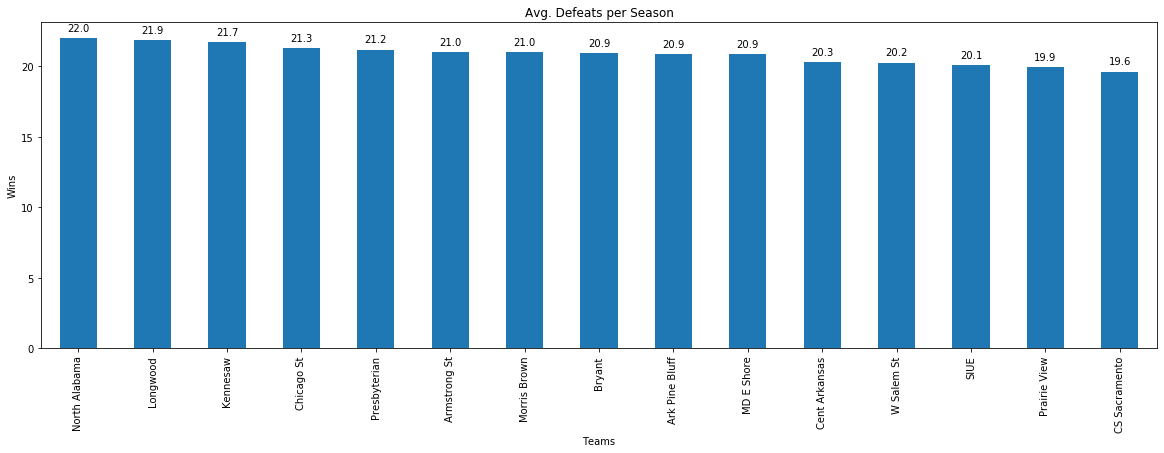

In [29]:
#import seaborn as sns
defeat_count = defeat_count.iloc[:15,:]
x_labels = defeat_count['TeamName']
counts = defeat_count['Result']

# Plot the figure.
plt.figure(figsize=(20, 6))
ax = counts.plot(kind='bar')
ax.set_title('Avg. Defeats per Season')
ax.set_xlabel('Teams')
ax.set_ylabel('Wins')
ax.set_xticklabels(x_labels)


    
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

# Call the function above. All the magic happens there.
add_value_labels(ax)

## Winning rate in cities (still need to work)

    - City data only has data from 2010

In [30]:
city_eda_win = final_data[final_data['CityID'].notna() & final_data['Result'] == 1]
city_eda_win

,Season,DayNum,TeamID,Score,Opp_TeamID,Opp_Score,WLoc,NumOT,CRType,match_up,...,City,State,Result,Seed_Group,Seed_Number,Seed,Opp_Seed_Group,Opp_Seed_Number,Team_Name,Opp_Team_Name
108122,2010,7,1143,75,1293,70,H,0,Regular,"[1143, 1293]",...,Berkeley,CA,1,NaN,NaN,NaN,NaN,NaN,California,Murray St
108123,2010,7,1314,88,1198,72,H,0,Regular,"[1198, 1314]",...,Chapel Hill,NC,1,NaN,NaN,NaN,NaN,NaN,North Carolina,Florida Intl
108124,2010,7,1326,100,1108,60,H,0,Regular,"[1108, 1326]",...,Columbus,OH,1,NaN,NaN,NaN,NaN,NaN,Ohio St,Alcorn St
108125,2010,7,1393,75,1107,43,H,0,Regular,"[1107, 1393]",...,Syracuse,NY,1,NaN,NaN,NaN,NaN,NaN,Syracuse,SUNY Albany
108126,2010,9,1143,95,1178,61,H,0,Regular,"[1143, 1178]",...,Berkeley,CA,1,NaN,NaN,NaN,NaN,NaN,California,Detroit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163798,2019,146,1120,77,1246,71,N,1,NCAA,"[1120, 1246]",...,Kansas City,MO,1,Y,05,Y02,Y,02,Auburn,Kentucky
163799,2019,146,1277,68,1181,67,N,0,NCAA,"[1181, 1277]",...,Washington,DC,1,W,02,W01,W,01,Michigan St,Duke
163800,2019,152,1403,61,1277,51,N,0,NCAA,"[1277, 1403]",...,Minneapolis,MN,1,X,03,W02,W,02,Texas Tech,Michigan St
163801,2019,152,1438,63,1120,62,N,0,NCAA,"[1120, 1438]",...,Minneapolis,MN,1,Z,01,Y05,Y,05,Virginia,Auburn


## Seed count per teams (need to work)

In [31]:
seed_eda = final_data[final_data['CRType'] == 'NCAA']
seed_eda

,Season,DayNum,TeamID,Score,Opp_TeamID,Opp_Score,WLoc,NumOT,CRType,match_up,...,City,State,Result,Seed_Group,Seed_Number,Seed,Opp_Seed_Group,Opp_Seed_Number,Team_Name,Opp_Team_Name
161552,1985,136,1116,63,1234,54,N,0,NCAA,"[1116, 1234]",...,NaN,NaN,1,X,09,X08,X,08,Arkansas,Iowa
161553,1985,136,1120,59,1345,58,N,0,NCAA,"[1120, 1345]",...,NaN,NaN,1,Z,11,Z06,Z,06,Auburn,Purdue
161554,1985,136,1207,68,1250,43,N,0,NCAA,"[1207, 1250]",...,NaN,NaN,1,W,01,W16,W,16,Georgetown,Lehigh
161555,1985,136,1229,58,1425,55,N,0,NCAA,"[1229, 1425]",...,NaN,NaN,1,Y,09,Y08,Y,08,Illinois St,USC
161556,1985,136,1242,49,1325,38,N,0,NCAA,"[1242, 1325]",...,NaN,NaN,1,Z,03,Z14,Z,14,Kansas,Ohio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327601,2019,146,1246,71,1120,77,N,1,NCAA,"[1120, 1246]",...,Kansas City,MO,0,Y,02,Y05,Y,05,Kentucky,Auburn
327602,2019,146,1181,67,1277,68,N,0,NCAA,"[1181, 1277]",...,Washington,DC,0,W,01,W02,W,02,Duke,Michigan St
327603,2019,152,1277,51,1403,61,N,0,NCAA,"[1277, 1403]",...,Minneapolis,MN,0,W,02,X03,X,03,Michigan St,Texas Tech
327604,2019,152,1120,62,1438,63,N,0,NCAA,"[1120, 1438]",...,Minneapolis,MN,0,Y,05,Z01,Z,01,Auburn,Virginia


In [32]:
np.sort(seed_eda['Seed_Number'].unique())

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16'], dtype=object)

### I need to come up with an idea how season_M data can be used (need to work on this)

In [33]:
season_M.info()
season_M

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Season   36 non-null     int64 
 1   DayZero  36 non-null     object
 2   RegionW  36 non-null     object
 3   RegionX  36 non-null     object
 4   RegionY  36 non-null     object
 5   RegionZ  36 non-null     object
dtypes: int64(1), object(5)
memory usage: 1.8+ KB


,Season,DayZero,RegionW,RegionX,RegionY,RegionZ
0,1985,10/29/1984,East,West,Midwest,Southeast
1,1986,10/28/1985,East,Midwest,Southeast,West
2,1987,10/27/1986,East,Southeast,Midwest,West
3,1988,11/2/1987,East,Midwest,Southeast,West
4,1989,10/31/1988,East,West,Midwest,Southeast
5,1990,10/30/1989,East,Midwest,Southeast,West
6,1991,10/29/1990,East,Southeast,Midwest,West
7,1992,11/4/1991,East,West,Midwest,Southeast
8,1993,11/2/1992,East,Midwest,Southeast,West
9,1994,11/1/1993,East,Southeast,Midwest,West


# Feature Engineering (Working on this)

- desired output:
    - index: TeamID
    - Season
    - DayNum or tourney stage or both: 
    - CityID
    - opponentID
    - Score per game within the season
    - Opp_Score per game within the season
    - SeedNumber
    - Opp_Seed_Number
    - Avg_Score_diff
    - Seed_diff
    - WinRate
    -
    - result: Result (W or L)

In [34]:
final_data

,Season,DayNum,TeamID,Score,Opp_TeamID,Opp_Score,WLoc,NumOT,CRType,match_up,...,City,State,Result,Seed_Group,Seed_Number,Seed,Opp_Seed_Group,Opp_Seed_Number,Team_Name,Opp_Team_Name
0,1985,20,1228,81,1328,64,N,0,Regular,"[1228, 1328]",...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,Illinois,Oklahoma
1,1985,25,1106,77,1354,70,H,0,Regular,"[1106, 1354]",...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,Alabama St,S Carolina St
2,1985,25,1112,63,1223,56,H,0,Regular,"[1112, 1223]",...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,Arizona,Houston Bap
3,1985,25,1165,70,1432,54,H,0,Regular,"[1165, 1432]",...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,Cornell,Utica
4,1985,25,1192,86,1447,74,H,0,Regular,"[1192, 1447]",...,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,F Dickinson,Wagner
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327601,2019,146,1246,71,1120,77,N,1,NCAA,"[1120, 1246]",...,Kansas City,MO,0,Y,02,Y05,Y,05,Kentucky,Auburn
327602,2019,146,1181,67,1277,68,N,0,NCAA,"[1181, 1277]",...,Washington,DC,0,W,01,W02,W,02,Duke,Michigan St
327603,2019,152,1277,51,1403,61,N,0,NCAA,"[1277, 1403]",...,Minneapolis,MN,0,W,02,X03,X,03,Michigan St,Texas Tech
327604,2019,152,1120,62,1438,63,N,0,NCAA,"[1120, 1438]",...,Minneapolis,MN,0,Y,05,Z01,Z,01,Auburn,Virginia


## Train Data

In [35]:
training_data = final_data[final_data['Season'] < 2015]
training_data = training_data.drop(['CityID','Score', 'Opp_Score', 'DayNum', 'WLoc','NumOT','CRType', 'match_up', 'City', 'State', 'Seed', 'Team_Name', 'Opp_Team_Name'], axis = 1)
training_data.dropna(inplace=True)

# convert some columns to numeric
training_data = training_data.astype({"Seed_Number": int, "Opp_Seed_Number": int}, errors='ignore')

training_data['Seed_diff'] = training_data['Seed_Number'] - training_data['Opp_Seed_Number']
#training_data['Score_diff'] = training_data['Score'] - training_data['Opp_Score']


training_data = pd.get_dummies(training_data)

# win rate
def reorder_team(TeamID, Opp_TeamID, Result):

    if TeamID > Opp_TeamID:
        TeamID, Opp_TeamID = Opp_TeamID, TeamID
        Result = 1 - Result

    return TeamID, Opp_TeamID, Result

# Generate data and get summary by team match-ups
TeamID, Opp_TeamID, Result = final_data['TeamID'], final_data['Opp_TeamID'], final_data['Result']

df = pd.DataFrame(data={'TeamID':TeamID,'Opp_TeamID':Opp_TeamID,'Result':Result}, dtype='int')
df = pd.DataFrame(df.apply(lambda x : reorder_team(x['TeamID'], x['Opp_TeamID'], x['Result']),axis=1).to_list(), 
                  columns=df.columns)


df_summary = df.groupby(['TeamID','Opp_TeamID']).agg(['sum','count'])
df_summary.columns = ['Wins', 'Total']

df_summary.reset_index(inplace=True)
df_summary['Team_Winrate'] = (df_summary['Wins'] / df_summary['Total'])

df_summary['Opp_Team_Winrate'] = 1 - df_summary['Team_Winrate']
df_summary = df_summary.sort_values('Total', ascending=False)
win_rate = df_summary[['TeamID', 'Opp_TeamID','Team_Winrate', 'Opp_Team_Winrate']]
training_data = pd.merge(training_data, win_rate,  how='left', on=['TeamID','Opp_TeamID'])

training_data.fillna(0.5, inplace=True)

# Rename 'Result' to 'Pred'
training_data = training_data.rename(columns = {'Result':'Pred'})

training_data

,Season,TeamID,Opp_TeamID,Pred,Seed_Number,Opp_Seed_Number,Seed_diff,Seed_Group_W,Seed_Group_X,Seed_Group_Y,Seed_Group_Z,Opp_Seed_Group_W,Opp_Seed_Group_X,Opp_Seed_Group_Y,Opp_Seed_Group_Z,Team_Winrate,Opp_Team_Winrate
0,1985,1116,1234,1,9,8,1,0,1,0,0,0,1,0,0,0.5,0.5
1,1985,1120,1345,1,11,6,5,0,0,0,1,0,0,0,1,0.5,0.5
2,1985,1207,1250,1,1,16,-15,1,0,0,0,1,0,0,0,1.0,0.0
3,1985,1229,1425,1,9,8,1,0,0,1,0,0,0,1,0,1.0,0.0
4,1985,1242,1325,1,3,14,-11,0,0,0,1,0,0,0,1,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3827,2014,1277,1163,0,4,7,-3,1,0,0,0,1,0,0,0,0.5,0.5
3828,2014,1276,1246,0,2,8,-6,0,0,1,0,0,0,1,0,0.5,0.5
3829,2014,1196,1163,0,1,7,-6,0,1,0,0,1,0,0,0,0.5,0.5
3830,2014,1458,1246,0,2,8,-6,0,0,0,1,0,0,1,0,0.5,0.5


## Test data

In [36]:
training_data
training_data.columns

,Season,TeamID,Opp_TeamID,Pred,Seed_Number,Opp_Seed_Number,Seed_diff,Seed_Group_W,Seed_Group_X,Seed_Group_Y,Seed_Group_Z,Opp_Seed_Group_W,Opp_Seed_Group_X,Opp_Seed_Group_Y,Opp_Seed_Group_Z,Team_Winrate,Opp_Team_Winrate
0,1985,1116,1234,1,9,8,1,0,1,0,0,0,1,0,0,0.5,0.5
1,1985,1120,1345,1,11,6,5,0,0,0,1,0,0,0,1,0.5,0.5
2,1985,1207,1250,1,1,16,-15,1,0,0,0,1,0,0,0,1.0,0.0
3,1985,1229,1425,1,9,8,1,0,0,1,0,0,0,1,0,1.0,0.0
4,1985,1242,1325,1,3,14,-11,0,0,0,1,0,0,0,1,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3827,2014,1277,1163,0,4,7,-3,1,0,0,0,1,0,0,0,0.5,0.5
3828,2014,1276,1246,0,2,8,-6,0,0,1,0,0,0,1,0,0.5,0.5
3829,2014,1196,1163,0,1,7,-6,0,1,0,0,1,0,0,0,0.5,0.5
3830,2014,1458,1246,0,2,8,-6,0,0,0,1,0,0,1,0,0.5,0.5


Index(['Season', 'TeamID', 'Opp_TeamID', 'Pred', 'Seed_Number',
       'Opp_Seed_Number', 'Seed_diff', 'Seed_Group_W', 'Seed_Group_X',
       'Seed_Group_Y', 'Seed_Group_Z', 'Opp_Seed_Group_W', 'Opp_Seed_Group_X',
       'Opp_Seed_Group_Y', 'Opp_Seed_Group_Z', 'Team_Winrate',
       'Opp_Team_Winrate'],
      dtype='object')

In [37]:
# Spliting ID into 3 different columns
submission_file['Season'] = submission_file['ID'].apply(lambda x: x.split("_")[0])
submission_file['TeamID'] = submission_file['ID'].apply(lambda x: x.split("_")[1])
submission_file['Opp_TeamID'] = submission_file['ID'].apply(lambda x: x.split("_")[2])

# Reorder the columns to move the target variable to the end
cols = ["Season", "TeamID", "Opp_TeamID", "Pred"]

# apply the corrected column order to the data frame
test_data = submission_file[cols]
test_data = test_data.astype('float')

# win rate
win_rate = df_summary.drop(['Wins', 'Total'], axis = 1)
test_data = pd.merge(test_data, win_rate,  how='left', on=['TeamID','Opp_TeamID'])
test_data.fillna(0.5, inplace=True)

# Seed information
tourney_seed_M['CRType'] = 'NCAA' # create a column in seed table to merge only on NCAA data.
test_data = pd.merge(test_data, tourney_seed_M, how = 'left', left_on=['Season', 'TeamID'], right_on=['Season','TeamID'])
test_data['Seed_Group'] = test_data['Seed'].apply(lambda x: x[0] if (np.all(pd.notnull(x))) else x)
test_data['Seed_Number'] = test_data['Seed'].apply(lambda x: x[1:3] if (np.all(pd.notnull(x))) else x)
test_data.drop(['Seed', 'CRType'], axis = 1, inplace =True)

opp_team_name = tourney_seed_M.rename(columns={"TeamID": "Opp_TeamID"})
test_data = pd.merge(test_data, opp_team_name, how = 'left', left_on=['Season', 'Opp_TeamID'], right_on=['Season','Opp_TeamID'])
test_data['Opp_Seed_Group'] = test_data['Seed'].apply(lambda x: x[0] if (np.all(pd.notnull(x))) else x)
test_data['Opp_Seed_Number'] = test_data['Seed'].apply(lambda x: x[1:3] if (np.all(pd.notnull(x))) else x)
test_data.drop(['Seed', 'CRType'], axis = 1, inplace =True)
test_data = test_data.astype({'Opp_Seed_Number': 'int32', 'Seed_Number': 'int32'})


# Seed difference
test_data = pd.get_dummies(test_data)
test_data['Seed_diff'] = test_data['Seed_Number'] - test_data['Opp_Seed_Number']


test_data

,Season,TeamID,Opp_TeamID,Pred,Team_Winrate,Opp_Team_Winrate,Seed_Number,Opp_Seed_Number,Seed_Group_W,Seed_Group_X,Seed_Group_Y,Seed_Group_Z,Opp_Seed_Group_W,Opp_Seed_Group_X,Opp_Seed_Group_Y,Opp_Seed_Group_Z,Seed_diff
0,2015.0,1107.0,1112.0,0.5,0.5,0.5,14,2,1,0,0,0,0,0,0,1,12
1,2015.0,1107.0,1116.0,0.5,0.5,0.5,14,5,1,0,0,0,0,0,0,1,9
2,2015.0,1107.0,1124.0,0.5,0.5,0.5,14,3,1,0,0,0,0,0,0,1,11
3,2015.0,1107.0,1125.0,0.5,0.5,0.5,14,15,1,0,0,0,1,0,0,0,-1
4,2015.0,1107.0,1129.0,0.5,0.0,1.0,14,11,1,0,0,0,1,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11385,2019.0,1449.0,1459.0,0.5,0.5,0.5,9,7,0,0,1,0,0,0,1,0,2
11386,2019.0,1449.0,1463.0,0.5,0.0,1.0,9,14,0,0,1,0,1,0,0,0,-5
11387,2019.0,1458.0,1459.0,0.5,1.0,0.0,5,7,0,0,0,1,0,0,1,0,-2
11388,2019.0,1458.0,1463.0,0.5,1.0,0.0,5,14,0,0,0,1,1,0,0,0,-9


# Dimension Reduction (Working on it)

    - Try UMAP to reduce the dimension and visualize it to see if we can find any meaningful information
    - Apply it on the training data set for now
    - For the future, apply it to find upsets.

In [41]:
import umap

features = training_data.drop('Pred', axis = 1)
label = training_data['Pred']

scaler = MinMaxScaler()
scaler.fit(features)
features = scaler.transform(features)



reducer = umap.UMAP()
embedding = reducer.fit_transform(features)
embedding.shape

MinMaxScaler(copy=True, feature_range=(0, 1))

(3832, 2)

In [42]:
new_label = []
new_names = []
for i in label:
    if i == 0:
        new_names.append('Defeat')
    elif i == 1:
        new_names.append('Win')

new_label = np.asarray(new_label)

In [44]:
rcParams['figure.figsize'] = 25, 12

output_notebook()


digits_df = pd.DataFrame(embedding, columns=('x', 'y'))
digits_df['label'] = [str(x) for x in new_names]
names = np.unique(label)

datasource = ColumnDataSource(digits_df)
color_mapping = CategoricalColorMapper(factors=[x for x in new_names], palette=Spectral6)

plot_figure = figure(
    title='UMAP projection of the NCAA dataset',
    plot_width=900,
    plot_height=700,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <span style='font-size: 16px; color: #224499'>label:</span>
        <span style='font-size: 18px'>@label</span>
    </div>
</div>
"""))

plot_figure.circle(
    'x',
    'y',
    source=datasource,
    color=dict(field='label', transform = color_mapping),
    line_alpha=0.7,
    fill_alpha=0.7,
    size=4
)


show(plot_figure)

Loading BokehJS ...

D:\Programming\Anaconda\envs\kaggle\lib\site-packages\bokeh\models\mappers.py:140: UserWarning: Palette length does not match number of factors. ['Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 'Win', 

GlyphRenderer(id='1126', ...)

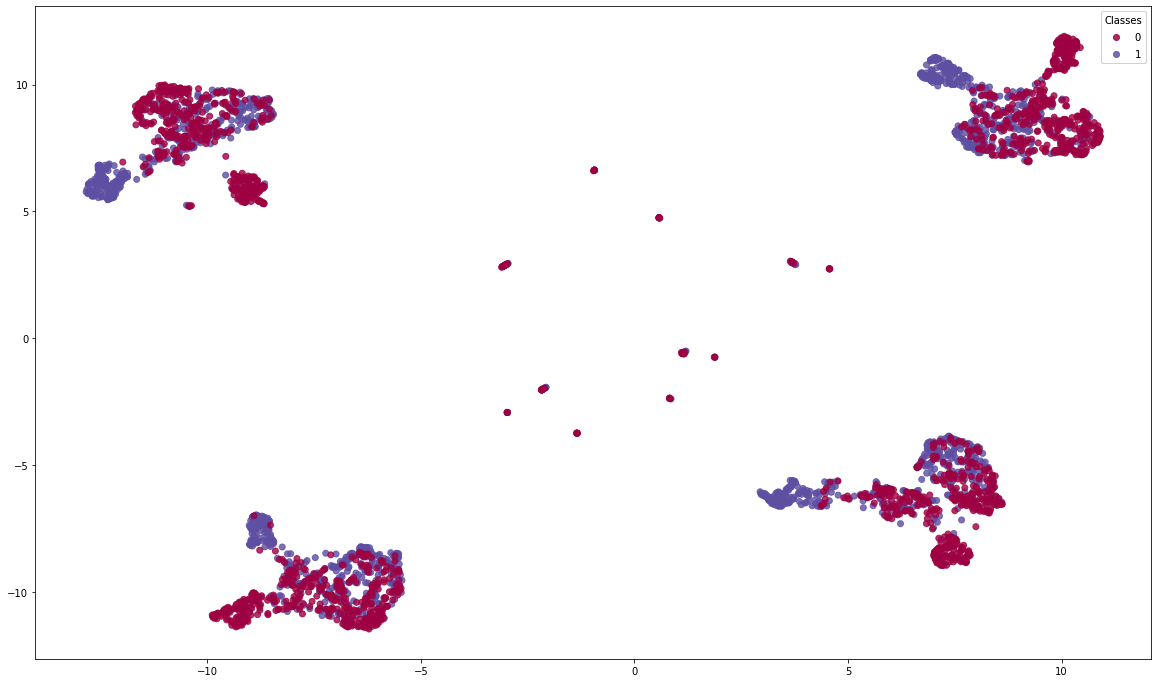

In [45]:
import matplotlib.cm as cm

rcParams['figure.figsize'] = 20, 12

N = 45
x, y = embedding[:, 0], embedding[:, 1]
c = label


#s = np.random.randint(10, 220, size=N)

fig, ax = plt.subplots()

scatter = ax.scatter(x, y, c=c, alpha=0.8, cmap=cm.Spectral)

legend1 = ax.legend(*scatter.legend_elements(), loc="best", title="Classes")
ax.add_artist(legend1)


plt.show()


# Model Selection (Still need to work)

## Functions

In [46]:
def train_test(features, labels):
    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.05, random_state = 42)

    return train_features, test_features, train_labels, test_labels
    
            
def important_variables(clf, features):
    # Saving feature names for later use
    feature_list = list(features.columns)
    # Convert to numpy array
    
    # Get numerical feature importances
    importances = list(clf.feature_importances_)
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];
    
    return feature_importances

def grid_search(model, train_features, train_labels, test_features):
    if model == 'GBR':
        model = GradientBoostingRegressor()
    elif model == 'RF':
        model = RandomForestRegressor()
        
    params = {'n_estimators' : [10,100,1000], 'max_depth' : [1,3,5,10,100], 'min_samples_leaf': [1,50,150,300]} 
    gs = GridSearchCV(model, params)
    gs.fit(train_features, train_labels)
    pred_tuned = gs.predict(test_features)
    
    print(gs.best_params_)
    return pred_tuned, gs


def performance_matric(test_labels, predictions, matric):
    if matric == 'mae':    
        mae = mean_absolute_error(test_labels, predictions)
        print("MAE: %.4f" % mae)
        
    else:
        print('Choose the right matric.')
    
    
def visualization(predictions_clf, test_labels):
    predictions_clf = pd.DataFrame(predictions_clf)
    predictions_clf.set_index(test_labels.index,inplace=True)

    comparison = pd.concat([test_labels, predictions_clf], axis=1, sort=True)
    comparison.rename(columns = {'time_to_failure': 'actual',  0:'prediction'}, inplace = True)

    
    comparison.plot
    # Plot the actual values
    plt.plot(comparison['actual'], 'b-', label = 'actual')
    # Plot the predicted values
    plt.plot(comparison['prediction'], 'ro', label = 'prediction')
    plt.xticks(rotation = '60'); 
    plt.legend()
    # Graph labels
    plt.xlabel('data'); plt.ylabel('Time to Failure'); plt.title('Actual and Predicted Values Gradient Boosting');


## Train Test Prep

In [58]:
features = training_data.drop('Pred', axis= 1)
labels = training_data['Pred']
submission_features = test_data.drop('Pred', axis=1)

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

print('Submission Features Shape:', submission_features.shape)


Training Features Shape: (2874, 16)
Training Labels Shape: (2874,)
Testing Features Shape: (958, 16)
Testing Labels Shape: (958,)
Submission Features Shape: (11390, 16)


In [48]:
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

## Modeling

### Baseline Model with Random Forest

In [49]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [50]:
# Use the forest's predict method on the test data
predictions_rf = rf.predict(test_features)

In [51]:
# Calculate the log loss
logloss = log_loss(test_labels, predictions_rf)
# Print out the mean absolute error (mae)
print('log_loss Error:', logloss)

log_loss Error: 0.43539385290822824


In [52]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Seed_diff            Importance: 0.21
Variable: Opp_Team_Winrate     Importance: 0.14
Variable: Team_Winrate         Importance: 0.13
Variable: TeamID               Importance: 0.12
Variable: Opp_TeamID           Importance: 0.12
Variable: Season               Importance: 0.1
Variable: Seed_Number          Importance: 0.05
Variable: Opp_Seed_Number      Importance: 0.05
Variable: Seed_Group_W         Importance: 0.01
Variable: Seed_Group_X         Importance: 0.01
Variable: Seed_Group_Y         Importance: 0.01
Variable: Seed_Group_Z         Importance: 0.01
Variable: Opp_Seed_Group_W     Importance: 0.01
Variable: Opp_Seed_Group_X     Importance: 0.01
Variable: Opp_Seed_Group_Y     Importance: 0.01
Variable: Opp_Seed_Group_Z     Importance: 0.01


In [53]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)
# Extract the two most important features
important_features = [feature_importances[0][0], feature_importances[1][0]]

train_important = train_features[important_features]
test_important = test_features[important_features]

# Train the random forest
rf_most_important.fit(train_important, train_labels)
# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)
errors = abs(predictions - test_labels.values)

# Display the performance metrics
log_loss(test_labels, predictions_rf)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

0.43539385290822824

In [54]:
rf = RandomForestRegressor()
params = {
    'n_estimators' : [10,100,1000],
    'max_depth' : [1,3,5,10,100],
    'min_samples_leaf': [1,50,150,300]
}
gs = GridSearchCV(rf, params)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

In [ ]:
gs.fit(features, labels)

In [ ]:
gs.best_score_

In [ ]:
preds = gs.best_estimator_.predict(submission_features)

### Gradient Boosting

In [76]:
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = GradientBoostingRegressor(**params)

model = clf.fit(train_features, train_labels)
predictions_clf = clf.predict(test_features)
logloss = log_loss(test_labels, predictions_clf)
print("logloss: %.4f" % logloss)

logloss: 0.4160


In [77]:
# Get numerical feature importances
importances = list(clf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Seed_diff            Importance: 0.33
Variable: Team_Winrate         Importance: 0.28
Variable: Opp_Team_Winrate     Importance: 0.26
Variable: Seed_Number          Importance: 0.04
Variable: Opp_TeamID           Importance: 0.03
Variable: Opp_Seed_Number      Importance: 0.03
Variable: TeamID               Importance: 0.02
Variable: Season               Importance: 0.01
Variable: Seed_Group_W         Importance: 0.0
Variable: Seed_Group_X         Importance: 0.0
Variable: Seed_Group_Y         Importance: 0.0
Variable: Seed_Group_Z         Importance: 0.0
Variable: Opp_Seed_Group_W     Importance: 0.0
Variable: Opp_Seed_Group_X     Importance: 0.0
Variable: Opp_Seed_Group_Y     Importance: 0.0
Variable: Opp_Seed_Group_Z     Importance: 0.0


In [78]:
# New random forest with only the two most important variables
clf_most_important = GradientBoostingRegressor(n_estimators= 1000, random_state=42)
# Extract the two most important features
important_features = [feature_importances[0][0], feature_importances[1][0]]

train_important = train_features[important_features]
test_important = test_features[important_features]

# Train the random forest
clf_most_important.fit(train_important, train_labels)

# Make predictions and determine the error
predictions = clf_most_important.predict(test_important)
logloss = log_loss(test_labels, predictions)

# Display the performance metrics
print('Log Loss:', logloss)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Log Loss: 0.6397616710618925


In [79]:
clf = GradientBoostingRegressor()
params = {
    'n_estimators' : [10,100,1000],
    'max_depth' : [1,3,5,10,100],
    'min_samples_leaf': [1,50,150,300]
}
gs = GridSearchCV(clf, params)
gs.fit(features, labels)
gs.best_score_

KeyboardInterrupt: 

In [277]:
preds_gradient_boost = gs.best_estimator_.predict(submission_features)

Log Loss: 0.6397741699891031


In [ ]:
logloss = log_loss(test_labels, predictions)

# Display the performance metrics
print('Log Loss:', logloss)

### Simple Neural Network (Not Started)

### Convolutional Neural Network

### Recurrent Neural Network

In [237]:
submission_file = submission_file[['ID','Pred']]
submission_file['Pred'] = predictions_rf

array([0.242, 0.523, 0.841, 0.   , 0.677, 0.   , 0.44 , 0.58 , 0.9  ,
       1.   , 0.68 , 0.992, 0.89 , 0.998, 0.63 , 1.   , 0.489, 0.   ,
       0.015, 0.205, 0.583, 0.159, 0.283, 0.091, 0.464, 1.   , 0.977,
       0.866, 0.   , 0.247, 0.379, 1.   , 0.409, 1.   , 0.142, 0.975,
       0.461, 0.843, 1.   , 0.363, 0.191, 0.536, 0.186, 0.523, 0.415,
       0.578, 0.608, 0.15 , 0.387, 0.418, 0.207, 0.864, 0.   , 0.435,
       0.586, 0.658, 0.164, 0.636, 0.037, 0.427, 0.541, 0.501, 0.001,
       0.999, 0.729, 0.45 , 0.817, 0.478, 0.373, 0.799, 0.187, 0.469,
       0.   , 0.   , 0.321, 1.   , 1.   , 0.45 , 0.428, 0.994, 0.535,
       1.   , 0.   , 0.551, 0.634, 0.419, 0.854, 0.358, 0.62 , 0.625,
       1.   , 0.442, 0.582, 0.071, 0.852, 0.   , 0.74 , 1.   , 0.582,
       0.33 , 0.724, 0.076, 0.   , 0.313, 0.506, 0.081, 1.   , 1.   ,
       0.537, 1.   , 1.   , 0.   , 0.436, 0.   , 1.   , 1.   , 0.   ,
       0.894, 1.   , 0.711, 0.   , 0.645, 0.608, 0.562, 0.   , 0.217,
       0.156, 0.999,

# Submission

In [75]:
training_data.columns

Index(['Season', 'TeamID', 'Opp_TeamID', 'Pred', 'Seed_Number',
       'Opp_Seed_Number', 'Seed_diff', 'Seed_Group_W', 'Seed_Group_X',
       'Seed_Group_Y', 'Seed_Group_Z', 'Opp_Seed_Group_W', 'Opp_Seed_Group_X',
       'Opp_Seed_Group_Y', 'Opp_Seed_Group_Z', 'Team_Winrate',
       'Opp_Team_Winrate'],
      dtype='object')

In [ ]:
prediction_df = pd.DataFrame({'Pred':preds})
prediction_df

submission = submission_file[['ID','Pred']]
submission['Pred'] = prediction_df['Pred']

submission
submission.to_csv('submission_file_.csv', index=False)

# Reference
- Primary: [google-cloud-ncaa-march-madness-2020-division-1-mens-tournament](https://www.kaggle.com/c/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament)
- Secondary: